<a href="https://colab.research.google.com/github/sunfflur/frequency-learning/blob/master/kylberg-texture-dataset/Exp_02_a_EfficientNetV2S_varyingdatasize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNetV2S

#### Libraries Import

In [ ]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
from tensorflow.random import set_seed
set_seed(s)

import PIL
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S#EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May  2 23:52:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


#### Drive mount

In [ ]:
### TESSSSSST ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 122523 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Data Load

In [ ]:
### data loading ### 
with tf.device('/CPU:0'):
  path_train = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_train.npy'
  path_ytrain = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_train.npy'
  path_test = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_test.npy'
  path_ytest = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_test.npy'

  x_train, x_test = np.load(path_train), np.load(path_test)
  y_train, y_test = np.load(path_ytrain), np.load(path_ytest)
  x_train, x_test = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1), x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

  # adjust dimension and change from array to tensor + convert to 3 channel images
  new_shape = (224,224)
  #new_shape = (384,384)
  x_train, x_test = tf.image.resize(x_train, new_shape), tf.image.resize(x_test, new_shape)
  x_train, x_test = tf.image.grayscale_to_rgb(x_train), tf.image.grayscale_to_rgb(x_test)
  y_train, y_test = tf.stack(to_categorical(y_train)), tf.stack(to_categorical(y_test))

In [ ]:
x_train.shape

TensorShape([3360, 224, 224, 3])

In [ ]:
y_train.shape

TensorShape([3360, 28])

In [ ]:
np.max(x_train)

255.0

#### Pre-trained model

In [ ]:
# prepare the image for the Xception model
x_train1 = preprocess_input(x_train)
x_test1 = preprocess_input(x_test)
del x_train
del x_test

In [ ]:
def pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    efficientnetv2s_model = EfficientNetV2S(include_top=True,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    if fine_tune > 0:
        for layer in efficientnetv2s_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in efficientnetv2s_model.layers:
            layer.trainable = False
    '''
    # Turn all the layers trainable.

    for layer in efficientnetv2s_model.layers:
      layer.trainable = True
    '''
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = efficientnetv2s_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=efficientnetv2s_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
tf.random.set_seed(s) #s
opt = Adam(learning_rate=0.0001)
EfficientNetV2S_model = pre_trained_model(input_shape=(384,384,3), n_classes=28, optimizer='Adam')

In [ ]:
print(EfficientNetV2S_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 384, 384, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# ModelCheckpoint callback - save best weights
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_efficientnetv2s_pt.weights.best.hdf5', save_best_only=True, verbose=0)
history = EfficientNetV2S_model.fit(x_train1, y_train, epochs=100, batch_size=16, verbose=1, shuffle=True, validation_split=0.1, callbacks=[checkpoint, estopping])

Epoch 1/100
189/189 [==============================] - 72s 280ms/step - loss: 0.6650 - accuracy: 0.9005 - val_loss: 0.0979 - val_accuracy: 1.0000
Epoch 2/100
189/189 [==============================] - 42s 222ms/step - loss: 0.0917 - accuracy: 0.9957 - val_loss: 0.0415 - val_accuracy: 1.0000
Epoch 3/100
189/189 [==============================] - 43s 228ms/step - loss: 0.0507 - accuracy: 0.9960 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 4/100
189/189 [==============================] - 41s 218ms/step - loss: 0.0365 - accuracy: 0.9954 - val_loss: 0.0160 - val_accuracy: 1.0000
Epoch 5/100
189/189 [==============================] - 43s 230ms/step - loss: 0.0247 - accuracy: 0.9970 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 6/100
189/189 [==============================] - 42s 220ms/step - loss: 0.0191 - accuracy: 0.9983 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 7/100
189/189 [==============================] - 43s 230ms/step - loss: 0.0162 - accuracy: 0.9987 - val_loss: 0.0076 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


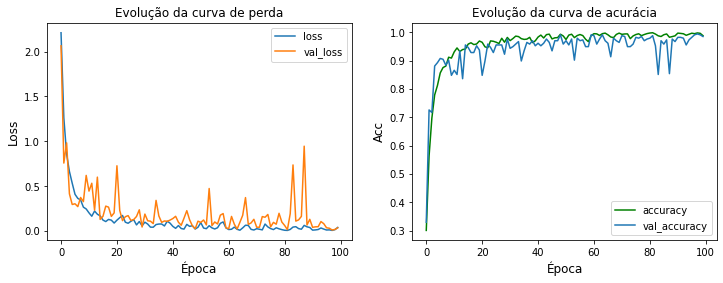

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
EfficientNetV2S_model.load_weights('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_efficientnetv2s_pt.weights.best.hdf5')

In [ ]:
### TEST ACC ###
scores = EfficientNetV2S_model.evaluate(x_test1, y_test)
print('\n%s : %.2f%%' % (EfficientNetV2S_model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 16s 326ms/step - loss: 9.5946e-05 - accuracy: 1.0000

accuracy : 100.00%


#### Random Initialization

##### DATA100

In [ ]:
# prepare the image for the Xception model
x_train1 = preprocess_input(x_train)
x_test1 = preprocess_input(x_test)
del x_train
del x_test

In [ ]:
def non_pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    efficientnetv2s_model = EfficientNetV2S(include_top=True,
                     weights=None, 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    '''
    if fine_tune > 0:
        for layer in resnet50_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in resnet50_model.layers:
            layer.trainable = False
    '''
    # Turn all the layers trainable.

    for layer in efficientnetv2s_model.layers:
      layer.trainable = True

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = efficientnetv2s_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=efficientnetv2s_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
tf.random.set_seed(s) #s
opt = Adam(learning_rate=0.0001)
EfficientNetV2S_model = non_pre_trained_model(input_shape=(224,224,3), n_classes=28, optimizer=opt)

In [ ]:
print(EfficientNetV2S_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# ModelCheckpoint callback - save best weights
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_efficientnetv2s_rdn.weights.best.hdf5', save_best_only=True, verbose=0)
history = EfficientNetV2S_model.fit(x_train1, y_train, epochs=100, batch_size=16, verbose=1, shuffle=True, validation_split=0.1, callbacks=[checkpoint, estopping])

Epoch 1/100
189/189 [==============================] - 83s 330ms/step - loss: 2.9356 - accuracy: 0.1237 - val_loss: 2.5081 - val_accuracy: 0.1369
Epoch 2/100
189/189 [==============================] - 58s 305ms/step - loss: 2.3215 - accuracy: 0.2460 - val_loss: 1.5609 - val_accuracy: 0.4940
Epoch 3/100
189/189 [==============================] - 55s 294ms/step - loss: 1.7105 - accuracy: 0.4312 - val_loss: 1.0611 - val_accuracy: 0.5804
Epoch 4/100
189/189 [==============================] - 56s 295ms/step - loss: 1.3973 - accuracy: 0.5222 - val_loss: 0.8757 - val_accuracy: 0.6637
Epoch 5/100
189/189 [==============================] - 55s 292ms/step - loss: 1.1154 - accuracy: 0.6181 - val_loss: 0.6018 - val_accuracy: 0.7649
Epoch 6/100
189/189 [==============================] - 57s 300ms/step - loss: 0.9006 - accuracy: 0.6994 - val_loss: 0.4093 - val_accuracy: 0.8423
Epoch 7/100
189/189 [==============================] - 46s 245ms/step - loss: 0.7723 - accuracy: 0.7553 - val_loss: 0.4599 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


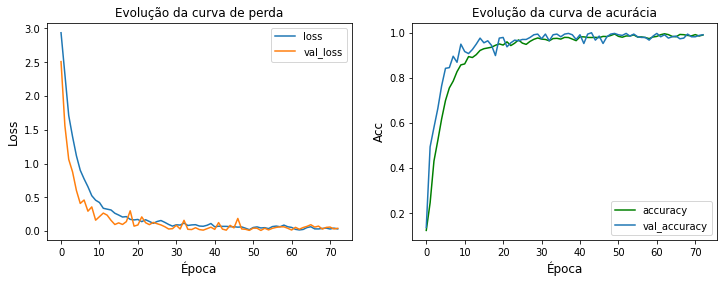

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show() #1h0min14s

In [ ]:
### TEST ACC ### EfficientNetV2S
scores = EfficientNetV2S_model.evaluate(x_test1, y_test)
print('\n%s : %.2f%%' % (EfficientNetV2S_model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 8s 127ms/step - loss: 0.0290 - accuracy: 0.9946

accuracy : 99.46%


In [ ]:
### TEST ACC ### EffcientNetV2B3
scores = EfficientNetV2S_model.evaluate(x_test1, y_test)
print('\n%s : %.2f%%' % (EfficientNetV2S_model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 9s 158ms/step - loss: 0.0129 - accuracy: 0.9937

accuracy : 99.37%


In [ ]:
#plot incorrect classifications

EfficientNetV2S_model.load_weights('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_efficientnetv2s_rdn.weights.best.hdf5')

In [ ]:
scores = EfficientNetV2S_model.evaluate(x_test1, y_test)
print('\n%s : %.2f%%' % (EfficientNetV2S_model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 15s 118ms/step - loss: 0.0448 - accuracy: 0.9848

accuracy : 98.48%


35/35 [==============================] - 4s 117ms/step


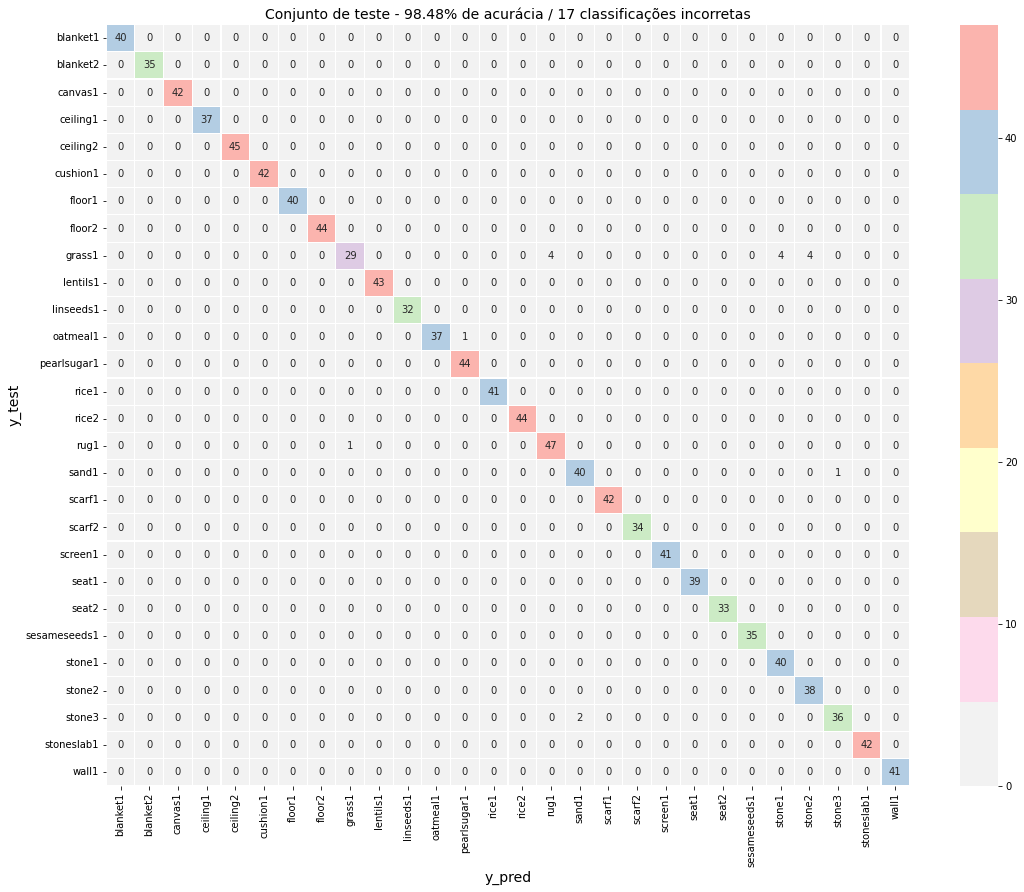

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

f=14

y_pred = EfficientNetV2S_model.predict(x_test1)
plt.figure(figsize = (18,14))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/x_test1.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros), fontsize=f)
labels = ['blanket1','blanket2','canvas1','ceiling1','ceiling2','cushion1',
       'floor1','floor2','grass1','lentils1','linseeds1','oatmeal1',
       'pearlsugar1','rice1','rice2','rug1','sand1','scarf1',
       'scarf2','screen1','seat1','seat2','sesameseeds1','stone1',
       'stone2','stone3','stoneslab1','wall1']
       
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True, fmt=".3g", xticklabels=labels, yticklabels=labels)
plt.xlabel('y_pred',fontsize=f)
plt.ylabel('y_test',fontsize=f)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
def incorrect_class_plot(data, x_test, y_test, model):
    dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
           6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
           12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
           18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
           24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

    y_pred = model.predict(data)
    dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
    indices = np.where(dif!=0)[0]
    plt.figure(figsize=(16,8))
    plt.subplot(131), plt.imshow(x_test[indices[0]]/255, cmap='gray')
    r1 = tf.argmax(y_test, axis=1)[indices[0]]
    f1 = tf.argmax(y_pred, axis=1)[indices[0]]
    p1=np.amax((y_pred)[indices[0]])

    #t1 = "Actual class = {}\nPredicted class = {}\nPrediction probability = {:.2f} %" \
    #            .format(dic[int(r1)], dic[int(f1)], p1*100)
    t1 = "Classe verdadeira = {}\nClasse predita = {}\nProbabilidade de predição = {:.2f} %" \
                .format(dic[int(r1)], dic[int(f1)], p1*100)
    #plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
    #plt.title('Class: %s - Prediction: %s' % (dic[int(r1)], dic[int(f1)]))
    plt.title(t1,fontsize=14)

    p2=np.amax((y_pred)[indices[1]])
    plt.subplot(132), plt.imshow(x_test[indices[1]]/255, cmap='gray')
    r2 = tf.argmax(y_test, axis=1)[indices[1]]
    f2 = tf.argmax(y_pred, axis=1)[indices[1]]
    #plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
    #plt.title('Class: %s - Prediction: %s' % (dic[int(r2)], dic[int(f2)]))
    #t2 = "Actual class = {}\nPredicted class = {}\nPrediction probability = {:.2f} %" \
    #            .format(dic[int(r2)], dic[int(f2)], p2*100)
    t2 = "Classe verdadeira = {}\nClasse predita = {}\nProbabilidade de predição = {:.2f} %" \
                .format(dic[int(r2)], dic[int(f2)], p2*100)
    plt.title(t2,fontsize=14)

    p3=np.amax((y_pred)[indices[2]])
    plt.subplot(133), plt.imshow(x_test[indices[2]]/255, cmap='gray')
    r3 = tf.argmax(y_test, axis=1)[indices[2]]
    f3 = tf.argmax(y_pred, axis=1)[indices[2]]
    t3 = "Classe verdadeira = {}\nClasse predita = {}\nProbabilidade de predição = {:.2f} %" \
                .format(dic[int(r3)], dic[int(f3)], p3*100)    
    plt.title(t3,fontsize=14)
    plt.show()

35/35 [==============================] - 4s 117ms/step


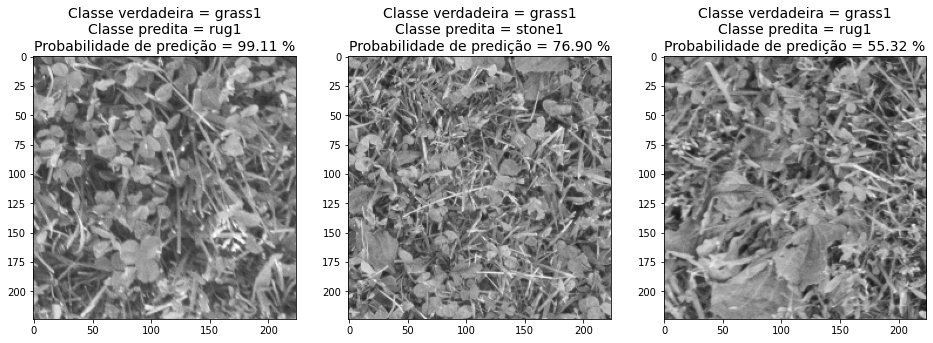

In [ ]:
incorrect_class_plot(x_test1, x_test=x_test, y_test=y_test, model=EfficientNetV2S_model)

##### VARYING DATA SIZE

In [ ]:
acc=[]
percents = [0.1, 0.25, 0.5, 0.75, 1.00]
for i in percents:
  tf.keras.backend.clear_session()
  print("Execucao {}".format(i))
  tf.random.set_seed(s) #s
  opt = Adam(learning_rate=0.0001)
  def split(x,y, test_size):
    x_train2, x_test2, y_train2, y_test2 = train_test_split(np.asarray(x), np.asarray(y), test_size=test_size, stratify=y)
    del x_train2
    del y_train2
    return x_test2, y_test2
  def non_pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    efficientnetv2s_model = EfficientNetV2S(include_top=True,
                     weights=None, 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    '''
    if fine_tune > 0:
        for layer in resnet50_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in resnet50_model.layers:
            layer.trainable = False
    '''
    # Turn all the layers trainable.

    for layer in efficientnetv2s_model.layers:
      layer.trainable = True

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = efficientnetv2s_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=efficientnetv2s_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
  #EfficientNetV2S_model = pre_trained_model(input_shape=(384,384,3), n_classes=28, optimizer='Adam')
  EfficientNetV2S_model = non_pre_trained_model(input_shape=(224,224,3), n_classes=28, optimizer=opt)
  if i !=1.00:
    print('<1')
    input_half, y_train_half = split(x_train1,y_train, i)
  else:
    print("Dataset Completo")
    input_half,y_train_half = x_train1,y_train
  # ModelCheckpoint callback - save best weights
  estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
  #checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_efficientnetv2s_pt.weights.best.hdf5', save_best_only=True, verbose=0)
  history = EfficientNetV2S_model.fit(input_half, y_train_half, epochs=100, batch_size=16, verbose=0, shuffle=True, validation_split=0.1, callbacks=[estopping]) #checkpoint, 
  scores = EfficientNetV2S_model.evaluate(x_test1, y_test)
  print('\n%s : %.2f%%' % (EfficientNetV2S_model.metrics_names[1], scores[1] * 100))
  acc.append(scores[1])
  del input_half
  del y_train_half
  del EfficientNetV2S_model
np.savetxt('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/acc_exp2_asoc_EfficientNetV2S.txt', acc)

Execucao 0.1
<1
35/35 [==============================] - 1s 26ms/step - loss: 1.0630 - accuracy: 0.6821

accuracy : 68.21%
Execucao 0.25
<1
35/35 [==============================] - 1s 27ms/step - loss: 0.4121 - accuracy: 0.8732

accuracy : 87.32%
Execucao 0.5
<1
35/35 [==============================] - 1s 26ms/step - loss: 0.1236 - accuracy: 0.9652

accuracy : 96.52%
Execucao 0.75
<1
35/35 [==============================] - 1s 26ms/step - loss: 0.0801 - accuracy: 0.9741

accuracy : 97.41%
Execucao 1.0
Dataset Completo
35/35 [==============================] - 6s 28ms/step - loss: 0.0092 - accuracy: 0.9946

accuracy : 99.46%
